In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

import scipy.stats as ss

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

from PIL import Image, ImageDraw, ImageFont
import PIL

import os

import copy
import random
import time

%matplotlib inline

(731, 522, 3)

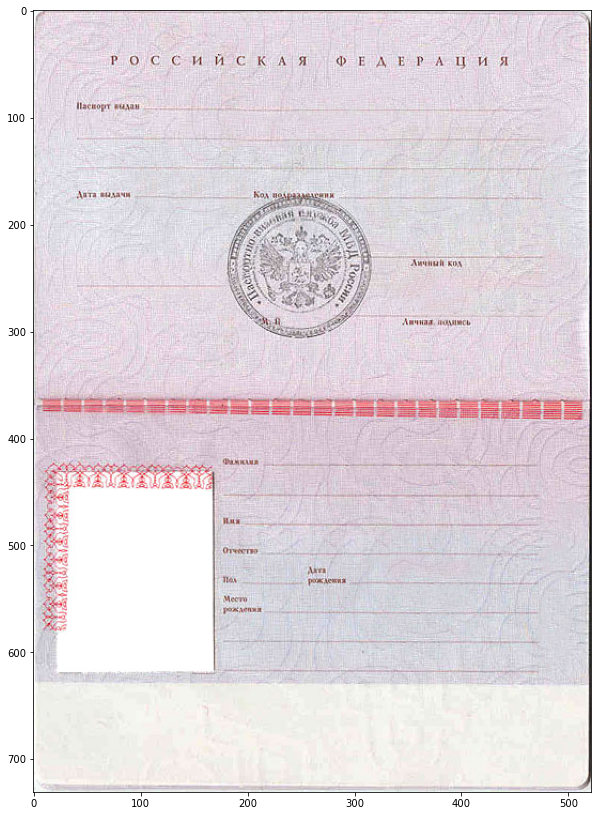

In [ ]:
passport = np.array(Image.open("passport_1.jpg"))
plt.figure(figsize=(10, 16))
plt.imshow(passport)
np.array(passport).shape

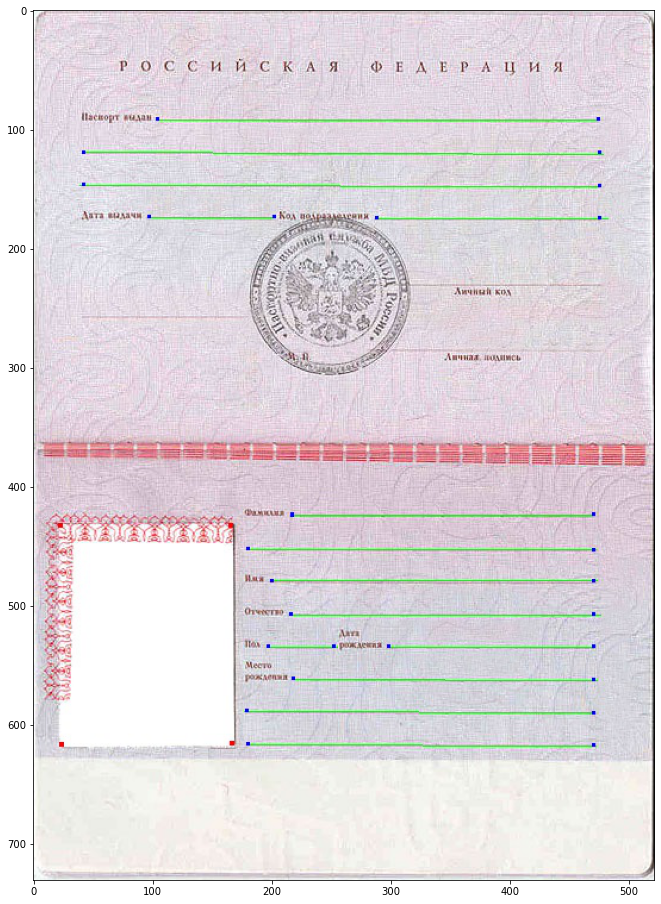

In [ ]:
img = np.array(Image.open("passport_marked.jpg"))[:, :522, :]
plt.figure(figsize=(16, 16))
plt.imshow(img)

In [ ]:
img2 = passport.copy()
mask = np.ones(img.shape[:2])
corners = []
for j, line in enumerate(img):
    for i, pix in enumerate(line):
        if pix[0] < 50 and pix[2] > 205 and pix[1] < 50 and mask[j, i]:
            print(f"({i}, {j})")
            corners.append([i, j])
            img2[j, i] = [255, 0, 0]
            mask[max(j - 0, 0): min(j + 10, 730), max(i - 10, 0): min(i + 10, 521)] = 0

(104, 90)
(474, 90)
(42, 118)
(475, 118)
(42, 146)
(475, 146)
(96, 172)
(202, 172)
(288, 173)
(475, 174)
(217, 422)
(470, 422)
(180, 451)
(470, 452)
(200, 478)
(469, 479)
(216, 506)
(470, 506)
(298, 533)
(470, 533)
(196, 534)
(252, 534)
(218, 560)
(470, 561)
(178, 588)
(470, 590)
(180, 615)
(470, 616)


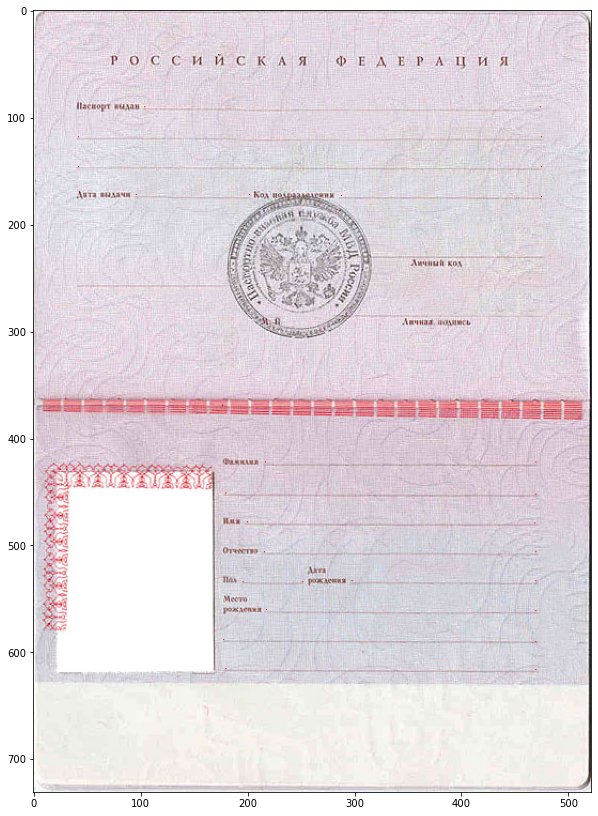

In [ ]:
plt.figure(figsize=(10, 16))
plt.imshow(img2)

In [ ]:
corners = np.array(corners).reshape(-1, 2, 2)

In [ ]:
for pair in corners:
    pair[:, 1] = pair[:, 1].min()

corners

array([[[104,  90],
        [474,  90]],

       [[ 42, 118],
        [475, 118]],

       [[ 42, 146],
        [475, 146]],

       [[ 96, 172],
        [202, 172]],

       [[288, 173],
        [475, 173]],

       [[217, 422],
        [470, 422]],

       [[180, 451],
        [470, 451]],

       [[200, 478],
        [469, 478]],

       [[216, 506],
        [470, 506]],

       [[298, 533],
        [470, 533]],

       [[196, 534],
        [252, 534]],

       [[218, 560],
        [470, 560]],

       [[178, 588],
        [470, 588]],

       [[180, 615],
        [470, 615]]])

In [ ]:
class TextField:
    def __init__(self, corners):
        self.corners_ = corners
        self.n_str = corners.shape[0]
        self.word = None
        self.font_size = 15
        
    def _write_short(self, img, text=None, line=0, determinized=False):
        text = text if text is not None else self.word
        w, h = img.size
        draw = ImageDraw.Draw(img)
        a, b = draw.textsize(text, font=ImageFont.truetype(passport_font, self.font_size))
        
        y_shift = np.random.choice(np.arange(max(1, b // 2))) * (1 - determinized)
        x_shift = np.random.choice(
            np.arange(max(1, (self.corners_[line, 1, 0] - self.corners_[line, 0, 0] - a) // 2))
        ) // 2 * np.random.choice([-1, 1]) * (1 - determinized)
        
        x = (self.corners_[line, 0, 0] + self.corners_[line, 1, 0] - a) / 2 + x_shift
        y = self.corners_[line, 0, 1] - b - y_shift
        draw.text((x, y), text, font=ImageFont.truetype(passport_font, self.font_size), fill=(50, 50, 50))
        return img
    
    def write_long(self, img, determinized=False):
        draw = ImageDraw.Draw(img)
        words = list(self.word.split())
        lengths = []
        for word in words:
            a, b = draw.textsize(word + " ", font=ImageFont.truetype(passport_font, self.font_size))
            lengths.append(a)
        w, h = img.size
        
        cur_len = 0
        line = 0
        cur_words = []
        for i in range(len(lengths)):
            if line == self.n_str - 1:
                text = ' '.join(cur_words + words[i:])
                img = self._write_short(img, line=line, text=text)
                return img
            cur_words.append(words[i])
            cur_len += lengths[i]
            if cur_len >= self.corners_[line, 1, 0] - self.corners_[line, 0, 0]:
                text = ' '.join(cur_words[:-1])
                img = self._write_short(img, line=line, text=text)
                cur_words = [words[i]]
                cur_len = lengths[i]
                line += 1
        text = ' '.join(cur_words)
        img = self._write_short(img, line=line, text=text)    
        
        return img
        

class Department(TextField):
    def __init__(self, corners):
        super().__init__(corners)
        self.word = "ГУ МВД РОССИИ ПО Г.САНКТ-ПЕТЕРБУРГУ И ЛЕНИНГРАДСКОЙ ОБЛАСТИ"
#         self.word = "ТП №8 ОТДЕЛА УФМС РОССИИ ПО САНКТ-ПЕТЕРБУРГУ И ЛЕНИНГРАДСКОЙ ОБЛАСТИ В ВАСИЛЕОСТРОВСКОМ Р-НЕ Г.САНКТ-ПЕТЕРБУРГА"

class Date(TextField):
    def __init__(self, corners):
        super().__init__(corners)
        self.word = "16.09.2016"
        self.font_size = 12

class DepCode(TextField):
    def __init__(self, corners):
        super().__init__(corners)
        self.word = "780-008"
        self.font_size = 12

class Surname(TextField):
    def __init__(self, corners):
        super().__init__(corners)
        self.word = "ПЕТРОВ"

class Name(TextField):
    def __init__(self, corners):
        super().__init__(corners)
        self.word = "ЛЕОНИД"

class SecondName(TextField):
    def __init__(self, corners):
        super().__init__(corners)
        self.word = "СЕРГЕЕВИЧ"

class Sex(TextField):
    def __init__(self, corners):
        super().__init__(corners)
        self.word = "МУЖ."

class BirthDate(TextField):
    def __init__(self, corners):
        super().__init__(corners)
        self.word = "17.06.2002"
        self.font_size = 12

class BirthPlace(TextField):
    def __init__(self, corners):
        super().__init__(corners)
        self.word = "Г. САНКТ-ПЕТЕРБУРГ"

In [ ]:
department = Department(corners[:3])
date = Date(corners[3: 4])
dep_code = DepCode(corners[4: 5])
surname = Surname(corners[5: 7])
name = Name(corners[7: 8])
second_name = SecondName(corners[8: 9])
sex = Sex(corners[10: 11])
birth_date = BirthDate(corners[9: 10])
birth_place = BirthPlace(corners[11: 14])

fields = [department, date, dep_code, surname, name, second_name, sex, birth_date, birth_place]

In [ ]:
FONTS = os.listdir("../fonts")
passport_font = '../fonts/ocrb.ttf'

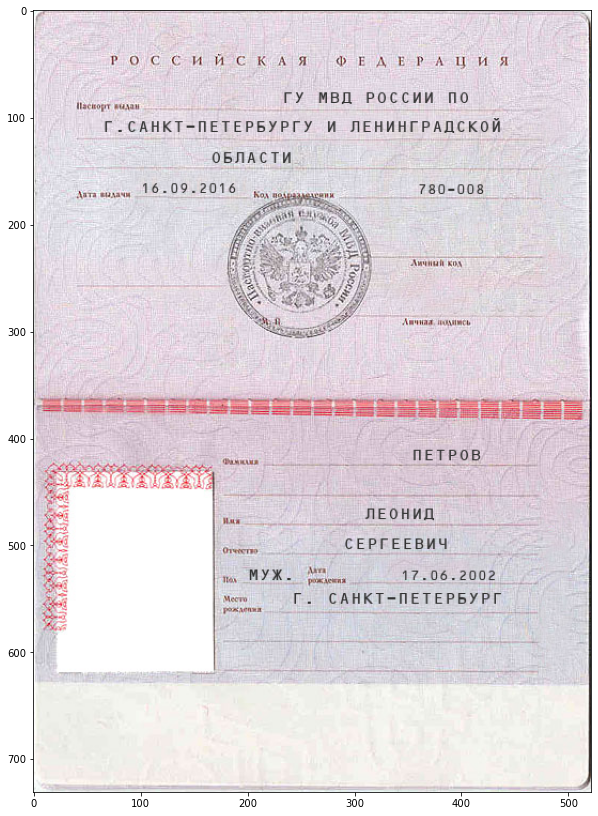

In [ ]:
passport_img = Image.open("passport_1.jpg")
plt.figure(figsize=(10, 16))

for field in fields:
    passport_img = field.write_long(passport_img)

plt.imshow(passport_img)
passport_img.save("filled.jpg")

In [ ]:
img2 = passport.copy()
mask = np.ones(img.shape[:2])
corners = []
for j, line in enumerate(img):
    for i, pix in enumerate(line):
        if pix[2] < 50 and pix[0] > 205 and pix[1] < 50 and mask[j, i]:
            print(f"({i}, {j})")
            corners.append([i, j])
            img2[j, i] = [0, 255, 0]
            mask[max(j - 0, 0): min(j + 10, 730), max(i - 10, 0): min(i + 10, 521)] = 0

(166, 431)
(21, 432)
(143, 441)
(26, 496)
(166, 614)
(23, 615)


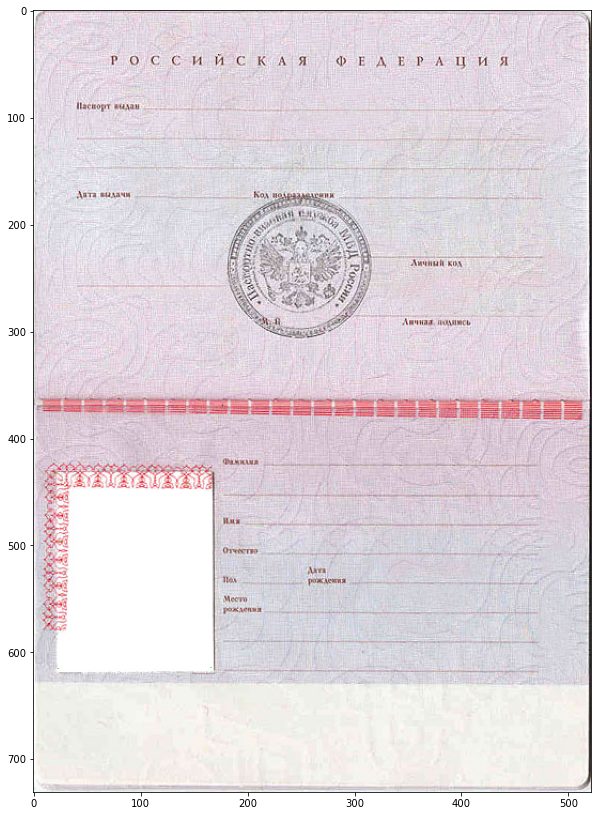

In [ ]:
plt.figure(figsize=(10, 16))
plt.imshow(img2)

# Passport photo

In [ ]:
photo_area = [
    (22, 430),
    (168, 430),
    (22, 618),
    (168, 618)
]

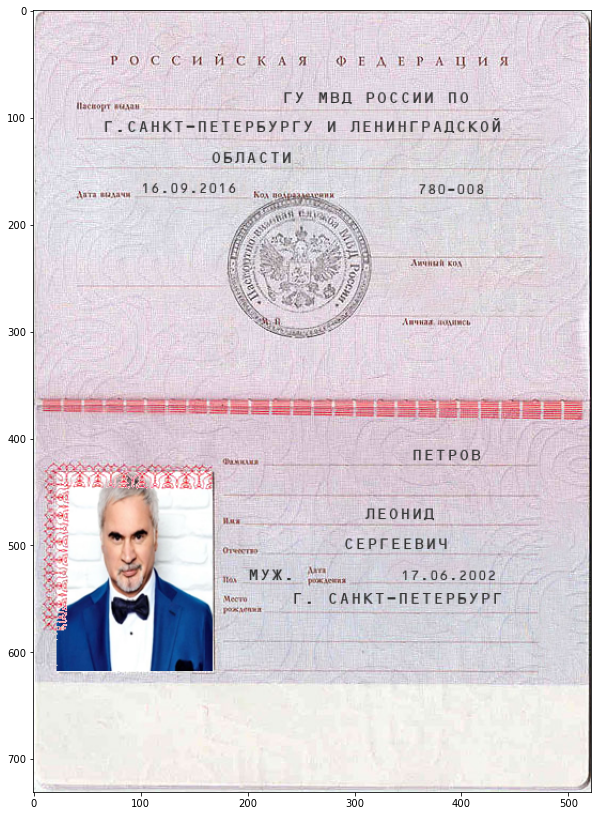

In [ ]:
passport_img2 = passport_img.copy()

photo = Image.open("meladze.jpg")
photo = photo.resize((168 - 22, 618 - 430))

passport_2_np = np.array(passport_img2)
mask_b = passport_2_np[430: 618, 22: 168, 2]

mask = (mask_b > 225).astype(np.uint8) * 255
mask_im = Image.fromarray(mask, mode='L')

passport_img2.paste(photo, (22, 430), mask_im)
    
plt.figure(figsize=(10, 16))
plt.imshow(passport_img2)
# passport_img2.save("meladze_passport.jpg")

In [ ]:
names, surnames, s_names = [], [], []
surnames_freqs = []

In [ ]:
with open("names_top100.txt", "r", encoding='utf-8') as file:
    for line in file:
        names.append(line.strip())

In [ ]:
with open("surnames_top500.txt", "r", encoding='utf-8') as file:
    words = list(file.readline().split())
    for i in range(0, len(words), 3):
        surnames.append(words[i + 1])
        surnames_freqs.append(float(words[i + 2].replace(',', '.')))

In [ ]:
with open("s_names_top100.txt", "r", encoding='utf-8') as file:
    for line in file:
        s_names.append(line.split()[0])

In [ ]:
import scipy.stats as ss

surnames_freqs = np.array(surnames_freqs) / np.sum(surnames_freqs)
Surname = ss.rv_discrete(values=(surnames, surnames_freqs))

Name = ss.rv_discrete(values=(names, [1 / len(names) for _ in range(names)]))

S_Name = ss.rv_discrete(values=(s_names, [1 / len(s_names) for _ in range(s_names)]))


NameError: name 'np' is not defined